# **Taller 6: agrupamiento usando K-means.**

**Curso: 09481 - Inteligencia Artificial.**

**Universidad Icesi.**

**Profesor: Breyner Posso.**

**Estudiantes: Daniela Olarte y Alexander Sanchez.**

En este taller vamos a aplicar el algoritmo de agrupación k-means en dos problemas.

# Parte 1.

## 0. Importar Librerías

In [2]:
#Librerías de interés.
import os

os.environ["OMP_NUM_THREADS"] = "1"

import pandas as pd                #Importamos la librería pandas. Nos va a servir para leer y manipular conjuntos de datos tabulares.
import matplotlib.pyplot as plt    #Importamos pyplot de librería matplotlib. Lo vamos a utilizar para graficar.
import seaborn as sns              #Importamos la librería Seaborn. La vamos a utilizar para graficar.
import numpy as np                 #Importamos la librería numpy para manipular arreglos. 
#from google.colab import files     #Esta librería nos sirve para cargar archivos desde el disco duro.

from sklearn.model_selection import train_test_split #Útil para dividir los conjuntos de datos. 
from sklearn.preprocessing import MinMaxScaler       #Útil para escalar los atributos de entrada.

from copy import deepcopy                            #Permite hacer copias profundas. 

from sklearn.cluster import KMeans                   #Clase que implementa k-means.
from sklearn.metrics import silhouette_samples       #Útil para calcular el valor de la silueta de una observación. 
from sklearn.metrics import silhouette_score         #Útil para calcular el valor de la silueta de todas las observaciones.
from sklearn.metrics import calinski_harabasz_score  #Útil para calcular el valor del índice Calinski Harabasz (CH).
from sklearn.metrics import confusion_matrix         #Permite extraer la matriz de confusión.

#!pip install yellowbrick --upgrade                   #Instala y actualiza la librería yellowbrick (la versión por defecto en Google Colab está desactualizada).
from yellowbrick.cluster import KElbowVisualizer     #Permite obtener la gráfica del codo para tres métricas diferentes (distorsión, silueta, CH).
from yellowbrick.cluster import SilhouetteVisualizer #Permite obtener la gráfica de las siluetas de cada grupo. 

# Parte 2.
Una compañía está interesada en realizar la segmentación de sus clientes de tal manera que pueda direccionar y adaptar sus campañas de marketing y fidelización a cada uno de los grupos encontrados.

## 1. Datos

In [3]:
# Vamos a leer el conjunto de datos en un dataframe de pandas. 
df = pd.read_csv('Mall_Customers.csv')

## 2. Análisis Exploratorio de Datos

In [4]:
df.shape

(200, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
df.tail()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18
199,200,Male,30,137,83


In [8]:
#Como no tenemos datos nulos, lo único que necesitamos hacer es cambiar el dtype de la columna 'Species' de object a category.
df['Genre'] = df['Genre'].astype('category')

In [9]:
df = df.replace(['Male','Female'],[0,1])

In [10]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


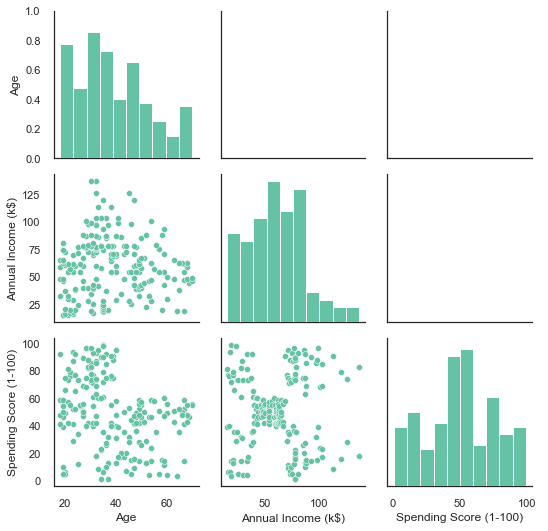

In [11]:
sns.set(style='white')  #Esto fija el estilo del fondo. Algunas opciones son: 'dark', 'white'
sns.set_palette('Set2') #Para otras opciones de paletas de colores, visite: https://seaborn.pydata.org/tutorial/color_palettes.html
g = sns.PairGrid(data=df.iloc[:,1:],diag_sharey=True)  #Note que no graficamos la columna 0 correspondiente a Id, 
                                                                     #pues no aporta información. Usamos las categorías de la columna de
                                                                     #'Species' para colorear las gráficas.
g.map_diag(plt.hist)        #Muestra gráficos de densidad 1D en la diagonal de la matriz. 
g.map_lower(sns.scatterplot)    #Muestra gráficos de dispersión en la sección inferior izquierda de la matriz.

g.add_legend()                  #Agrega la leyenda de las especies.
plt.show()

# **EJERCICIOS PROPUESTOS TALLER 6.**

## Constantes

### Rango de normalización

In [12]:
range = (0, 1)
scaler = MinMaxScaler(feature_range=range)

### Parámetros para el split

In [13]:
mix = True
seed = 42

partition = 0.2

### Hiperparámetros para el modelo

In [14]:
kmin              = 1           
kmax              = 10          
init              ='k-means++'  
n_init            = 10            
                                
max_iter          = 300         
random_seed       = 42

## Ejercicio 1.

Realice la mejor agrupación de los clientes de acuerdo con el Ingreso Anual y el Spending Score. Pruebe diferentes valores de k, normalice si considera necesario y use las diferentes métricas para comparar el desempeño de las agrupaciones.

¿Cuántos grupos encontró? ¿Qué 'insights' se pueden extraer de esta segmentación de los clientes?

In [15]:
input = ['Annual Income (k$)', 'Spending Score (1-100)']
df_x = deepcopy(df[input])

In [16]:
df_x_norm = deepcopy(df_x) 
df_x_norm[input] = scaler.fit_transform(df_x)

### Modelo

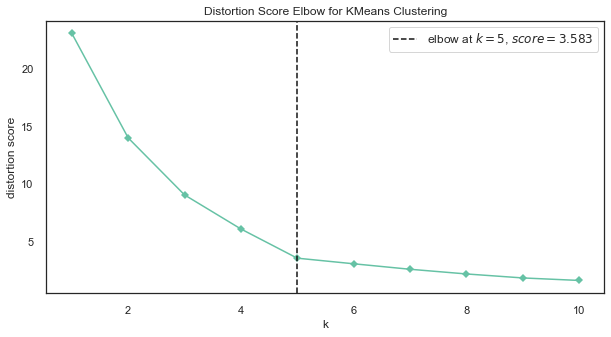

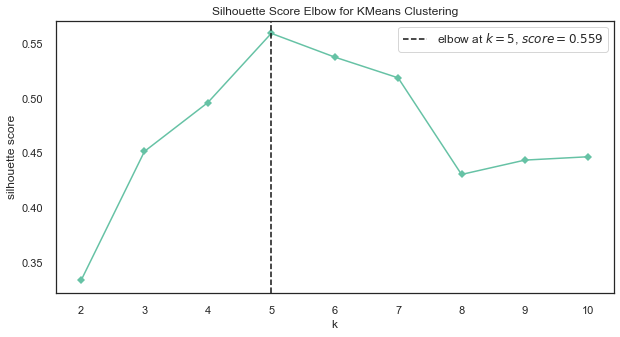

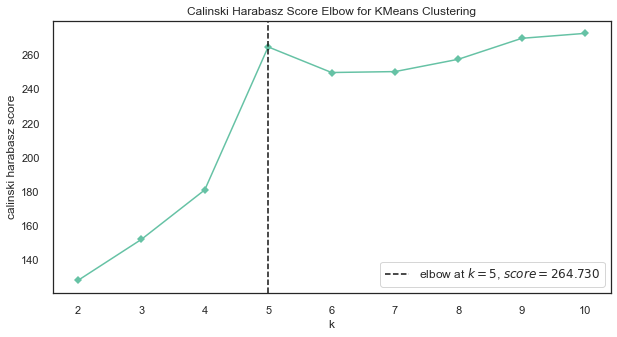

In [17]:
model = KMeans(init=init,
               n_init=n_init, 
               max_iter=max_iter, 
               random_state=random_seed)

for metric in ['distortion', 'silhouette', 'calinski_harabasz']:
    if metric=="silhouette" or metric=="calinski_harabasz":  
        kmin_ = max(2,kmin)
    else:
        kmin_ = kmin

    plt.figure(figsize=(10,5)) 

    visualizer = KElbowVisualizer(estimator=model, 
                                 k=(kmin_, kmax+1), 
                                 metric=metric, 
                                 timings=False,
                                 locate_elbow=True)
    visualizer.fit(df_x_norm)        
    visualizer.show()                 

### Entrenamiento

In [18]:
k = 5

kmeans = KMeans(init=init,
                n_clusters=k,
                n_init=n_init,
                max_iter=max_iter,
                random_state=random_seed)

kmeans.fit(df_x_norm)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print('Centroides:', centroids)
print('Etiquetas:', np.unique(labels))



Centroides: [[0.33029751 0.49508692]
 [0.6        0.16443149]
 [0.09265859 0.20319432]
 [0.08792846 0.79962894]
 [0.58638083 0.82783883]]
Etiquetas: [0 1 2 3 4]


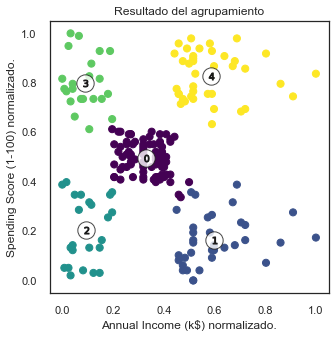

In [19]:
plt.figure(figsize=(5,5))
plt.scatter(df_x_norm.iloc[:,0],   df_x_norm.iloc[:,1], c=labels.reshape((-1,1)), s=50,  cmap='viridis')  #Observaciones.
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', color='white', edgecolor='k', s=300, alpha=0.8)       #Centroides.
plt.xlabel(df_x_norm.columns[0]+' normalizado.')
plt.ylabel(df_x_norm.columns[1]+' normalizado.')

for i, c in enumerate(centroids):
  plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.title('Resultado del agrupamiento')
plt.show()

* El resultado son 5 centroides en torno a los cuales se agrupan los puntos y las etiquetas para cada punto que indican a qué cluster pertenece dicho punto
* Las perspectivas que se pueden extraer de esta segmentación es que al evaluar los 5 centroides que se encuentran, el grupo 0 es el que cuenta con datos mejor agrupados en comparación con los otros grupos donde los datos se encuentran a mayor distancia del centroide. 
* De acuerdo con las graficas del codo, silhoutte y calinski se puede evidenciar que k=5 es el mejor valor que se puede presentar para el mismo. 

## Ejercicio 2.

Realice la mejor agrupación de los clientes de acuerdo con la Edad y el Spending Score. Pruebe diferentes valores de k, normalice si considera necesario y use las diferentes métricas para comparar el desempeño de las agrupaciones.

¿Cuántos grupos encontró? ¿Qué 'insights' se pueden extraer de esta segmentación de los clientes?

In [36]:
input = ['Age', 'Spending Score (1-100)']
df_x = deepcopy(df[input])

In [37]:
df_x_norm = deepcopy(df_x) 
df_x_norm[input] = scaler.fit_transform(df_x)

### Modelo

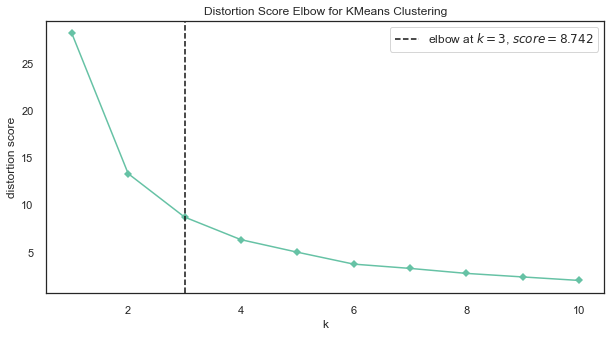

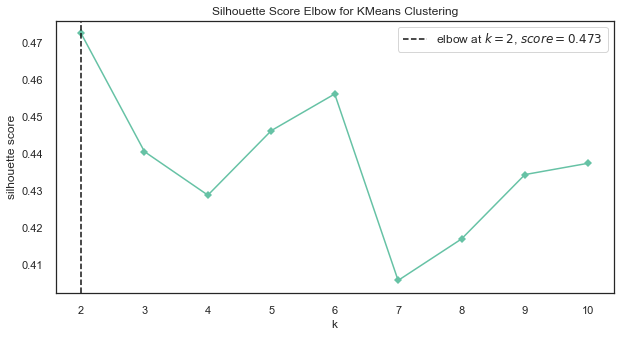

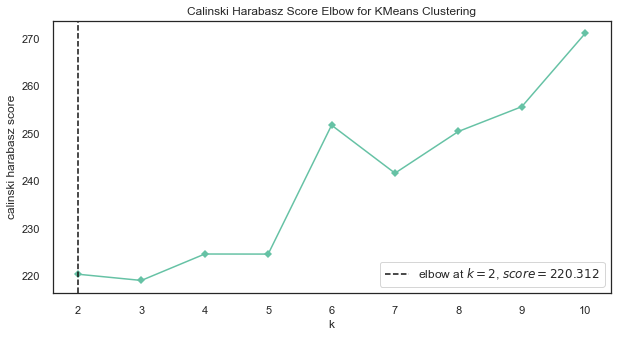

In [38]:
model = KMeans(init=init,
               n_init=n_init, 
               max_iter=max_iter, 
               random_state=random_seed)

for metric in ['distortion', 'silhouette', 'calinski_harabasz']:
    if metric=="silhouette" or metric=="calinski_harabasz":  
        kmin_ = max(2,kmin)
    else:
        kmin_ = kmin

    plt.figure(figsize=(10,5)) 

    visualizer = KElbowVisualizer(estimator=model, 
                                 k=(kmin_, kmax+1), 
                                 metric=metric, 
                                 timings=False,
                                 locate_elbow=True)
    visualizer.fit(df_x_norm)        
    visualizer.show() 

In [39]:
k = 3

kmeans = KMeans(init=init,
                n_clusters=k,
                n_init=n_init,
                max_iter=max_iter,
                random_state=random_seed)

kmeans.fit(df_x_norm)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print('Centroides:', centroids)
print('Etiquetas:', np.unique(labels))

Centroides: [[0.20565611 0.73961585]
 [0.7323201  0.40108624]
 [0.32656023 0.23912206]]
Etiquetas: [0 1 2]


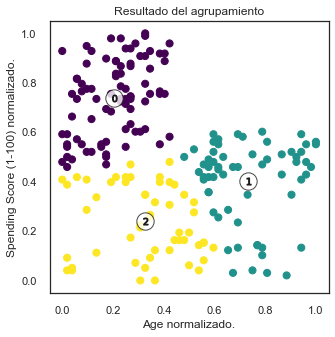

In [40]:
plt.figure(figsize=(5,5))
plt.scatter(df_x_norm.iloc[:,0],   df_x_norm.iloc[:,1], c=labels.reshape((-1,1)), s=50,  cmap='viridis')  #Observaciones.
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', color='white', edgecolor='k', s=300, alpha=0.8)       #Centroides.
plt.xlabel(df_x_norm.columns[0]+' normalizado.')
plt.ylabel(df_x_norm.columns[1]+' normalizado.')

for i, c in enumerate(centroids):
  plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.title('Resultado del agrupamiento')
plt.show()

In [24]:
k = 5

kmeans = KMeans(init=init,
                n_clusters=k,
                n_init=n_init,
                max_iter=max_iter,
                random_state=random_seed)

kmeans.fit(df_x_norm)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print('Centroides:', centroids)
print('Etiquetas:', np.unique(labels))

Centroides: [[0.36929553 0.31163817]
 [0.37861485 0.73950929]]
Etiquetas: [0 1]


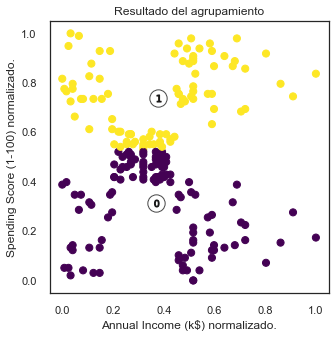

In [25]:
plt.figure(figsize=(5,5))
plt.scatter(df_x_norm.iloc[:,0],   df_x_norm.iloc[:,1], c=labels.reshape((-1,1)), s=50,  cmap='viridis')  #Observaciones.
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', color='white', edgecolor='k', s=300, alpha=0.8)       #Centroides.
plt.xlabel(df_x_norm.columns[0]+' normalizado.')
plt.ylabel(df_x_norm.columns[1]+' normalizado.')

for i, c in enumerate(centroids):
  plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.title('Resultado del agrupamiento')
plt.show()

* El resultado son 2 centroides en torno a los cuales se agrupan los puntos y las etiquetas para cada punto que indican a qué cluster pertenece dicho punto
* Las perspectivas que se pueden extraer de esta segmentación es que al evaluar los 2 centroides que se encuentran, el grupo 1 es el que cuenta con datos mejor agrupados en comparación con el grupo 0. 
* De acuerdo con las graficas del codo, silhoutte y calinski se puede evidenciar que la grafica del codo sugiere que el mejor k es 3 mientras que para silhoutte y calinski sigiere que el mejor k es 2. Al probar con ambos k, el mejor k resultó ser 2 y se puede evidenciar debido a que se sus datos son mas agrupados.

## Ejercicio 3.

Realice la mejor agrupación de los clientes de acuerdo con el Género y el Spending Score. Pruebe diferentes valores de k, normalice si considera necesario y use las diferentes métricas para comparar el desempeño de las agrupaciones.

¿Cuántos grupos encontró? ¿Qué 'insights' se pueden extraer de esta segmentación de los clientes?

In [26]:
input = ['Genre', 'Spending Score (1-100)']
df_x = deepcopy(df[input])

In [27]:
df_x_norm = deepcopy(df_x) 
df_x_norm[input] = scaler.fit_transform(df_x)

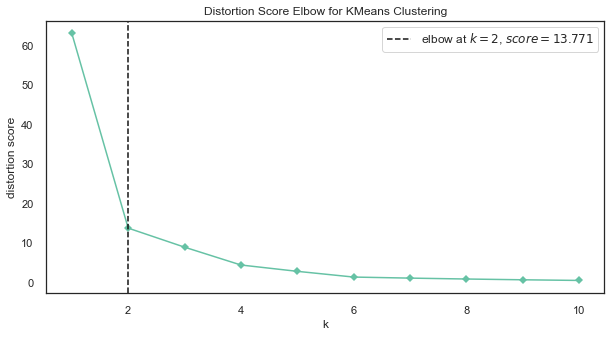

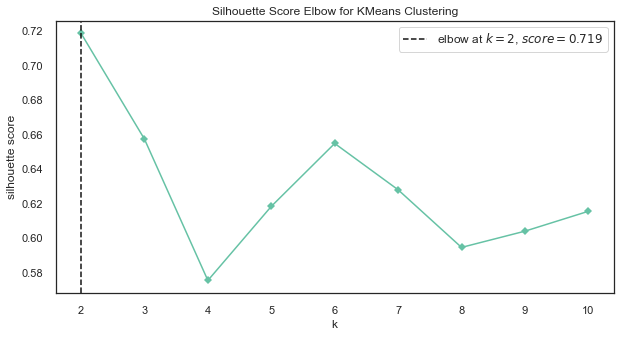

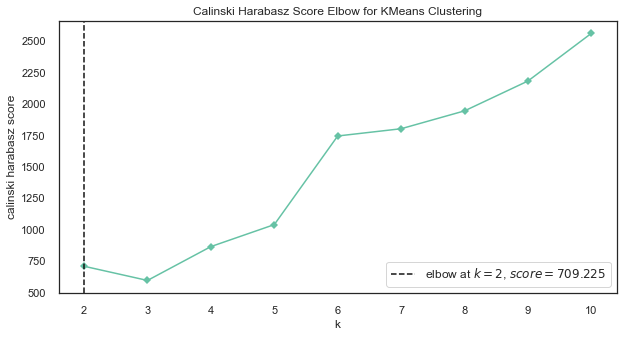

In [28]:
model = KMeans(init=init,
               n_init=n_init, 
               max_iter=max_iter, 
               random_state=random_seed)

for metric in ['distortion', 'silhouette', 'calinski_harabasz']:
    if metric=="silhouette" or metric=="calinski_harabasz":  
        kmin_ = max(2,kmin)
    else:
        kmin_ = kmin

    plt.figure(figsize=(10,5)) 

    visualizer = KElbowVisualizer(estimator=model, 
                                 k=(kmin_, kmax+1), 
                                 metric=metric, 
                                 timings=False,
                                 locate_elbow=True)
    visualizer.fit(df_x_norm)        
    visualizer.show() 

In [29]:
k = 2

kmeans = KMeans(init=init,
                n_clusters=k,
                n_init=n_init,
                max_iter=max_iter,
                random_state=random_seed)

kmeans.fit(df_x_norm)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print('Centroides:', centroids)
print('Etiquetas:', np.unique(labels))

Centroides: [[-4.44089210e-16  4.84809833e-01]
 [ 1.00000000e+00  5.15579446e-01]]
Etiquetas: [0 1]


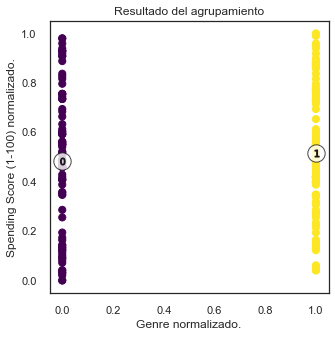

In [30]:
plt.figure(figsize=(5,5))
plt.scatter(df_x_norm.iloc[:,0],   df_x_norm.iloc[:,1], c=labels.reshape((-1,1)), s=50,  cmap='viridis')  #Observaciones.
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', color='white', edgecolor='k', s=300, alpha=0.8)       #Centroides.
plt.xlabel(df_x_norm.columns[0]+' normalizado.')
plt.ylabel(df_x_norm.columns[1]+' normalizado.')

for i, c in enumerate(centroids):
  plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.title('Resultado del agrupamiento')
plt.show()

* El resultado son 2 centroides en torno a los cuales se agrupan los puntos y las etiquetas para cada punto que indican a qué cluster pertenece dicho punto.
* Las perspectivas que se pueden extraer de esta segmentación es que al evaluar los 2 centroides que se encuentran, el grupo 1 es el que cuenta con datos mejor agrupados en comparación con el grupo 0.
* De acuerdo con las graficas del codo, silhoutte y calinski se puede evidenciar que k=2 es el mejor valor que se puede presentar para el mismo.

## Ejercicio 4.

Realice la mejor una segmentación de clientes usando tres atributos: el Spending Score y otros dos que usted considere interesantes. Pruebe diferentes valores de k, normalice si considera necesario y use las diferentes métricas para comparar el desempeño de las agrupaciones.

¿Cuántos grupos encontró? ¿Qué 'insights' se pueden extraer de esta segmentación de los clientes?

In [31]:
input = ['Spending Score (1-100)', 'Annual Income (k$)', 'Age']
df_x = deepcopy(df[input])

In [32]:
df_x_norm = deepcopy(df_x) 
df_x_norm[input] = scaler.fit_transform(df_x)

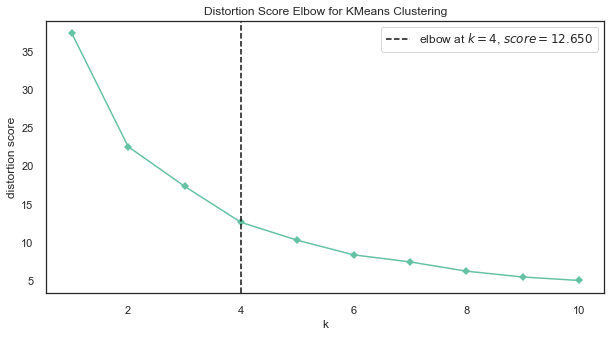

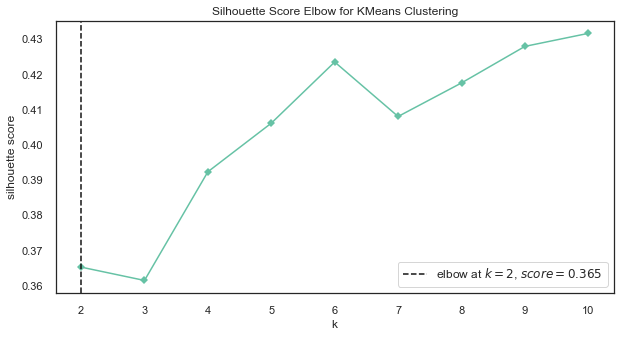

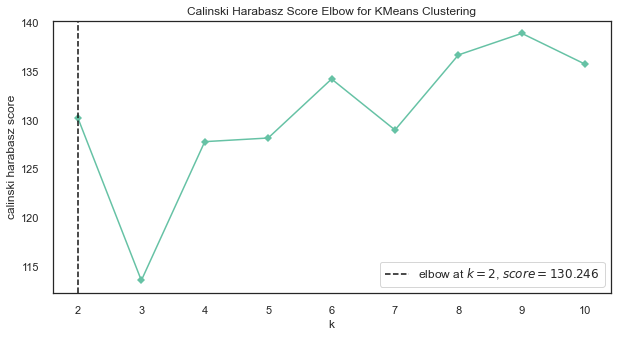

In [33]:
model = KMeans(init=init,
               n_init=n_init, 
               max_iter=max_iter, 
               random_state=random_seed)

for metric in ['distortion', 'silhouette', 'calinski_harabasz']:
    if metric=="silhouette" or metric=="calinski_harabasz":  
        kmin_ = max(2,kmin)
    else:
        kmin_ = kmin

    plt.figure(figsize=(10,5)) 

    visualizer = KElbowVisualizer(estimator=model, 
                                 k=(kmin_, kmax+1), 
                                 metric=metric, 
                                 timings=False,
                                 locate_elbow=True)
    visualizer.fit(df_x_norm)        
    visualizer.show() 

In [34]:
k = 4

kmeans = KMeans(init=init,
                n_clusters=k,
                n_init=n_init,
                max_iter=max_iter,
                random_state=random_seed)

kmeans.fit(df_x_norm)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print('Centroides:', centroids)
print('Etiquetas:', np.unique(labels))

Centroides: [[0.60508414 0.20491803 0.14304993]
 [0.1895811  0.58606557 0.41093117]
 [0.39764521 0.26809584 0.69201183]
 [0.82168367 0.58278689 0.28605769]]
Etiquetas: [0 1 2 3]


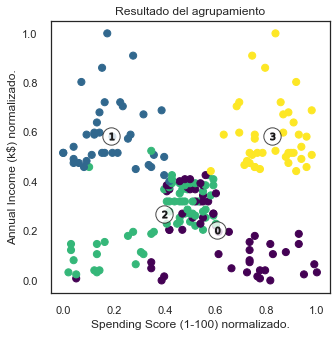

In [35]:
plt.figure(figsize=(5,5))
plt.scatter(df_x_norm.iloc[:,0],   df_x_norm.iloc[:,1], c=labels.reshape((-1,1)), s=50,  cmap='viridis')  #Observaciones.
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', color='white', edgecolor='k', s=300, alpha=0.8)       #Centroides.
plt.xlabel(df_x_norm.columns[0]+' normalizado.')
plt.ylabel(df_x_norm.columns[1]+' normalizado.')

for i, c in enumerate(centroids):
  plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.title('Resultado del agrupamiento')
plt.show()

* El resultado son 4 centroides en torno a los cuales se agrupan los puntos y las etiquetas para cada punto que indican a qué cluster pertenece dicho punto.
* Las perspectivas que se pueden extraer de esta segmentación es que al evaluar los 4 centroides que se encuentran, el grupo 3 es el que cuenta con datos mejor agrupados en comparación con los otros grupos. 
* De acuerdo con las graficas del codo, silhoutte y calinski se puede evidenciar que la grafica del codo sugiere que el mejor k es 4 mientras que para silhoutte y calinski sigiere que el mejor k es 2. Al probar con ambos k, el mejor k resultó ser 4 y se puede evidenciar debido a que se sus datos son mas agrupados.

# **Metodología**

1. Desarrolle de forma individual las preguntas propuestas en el Taller 6.

2. Después de la sesión de Taller 6, suba a Intu el archivo con la solución a las preguntas con nombre en el siguiente formato:

Taller_6_Apellido-Nombre.ipynb

3. Resuelva los Ejercicios Propuestos (en grupos de máximo 2 personas) en un nuevo notebook de Jupyter y suba el archivo a Intu hasta el próximo miércoles 12 de octubre a las 7:00 am (antes del inicio de la clase). Utilice el siguiente formato para el nombre del archivo.

Ejercicios_Taller_6_Apellido-Nombre_Apellido-Nombre.ipynb

4.	Recuerde consignar los nombres de los integrantes dentro del notebook.

5.	Algunos grupos serán llamados al azar durante la clase para realizar la presentación de los resultados de los Ejercicios Propuestos.

6. La nota del Taller 6 se asignará así:

- Preguntas Taller 6 (20%)

- Ejercicios Taller 6 (80%)